# Optional: Batch Normalization

In this Notebook we introduce the idea of Batch Normalization and how it aids in Neural Network training. 

By completing this exercise you will:
1. Know the implementation details of Batch Norm
2. Notice the difference in behaviour during train and test time
3. Use Batch Norm in a Fully Connected Layer to see how it affects training

## What is Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was proposed by [1].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.


## Before We Start

It is important that we take a look at the Mathematical formula behind Batch Norm. Please take a good look at the formula since this would be really helpful in the actual code implementation.

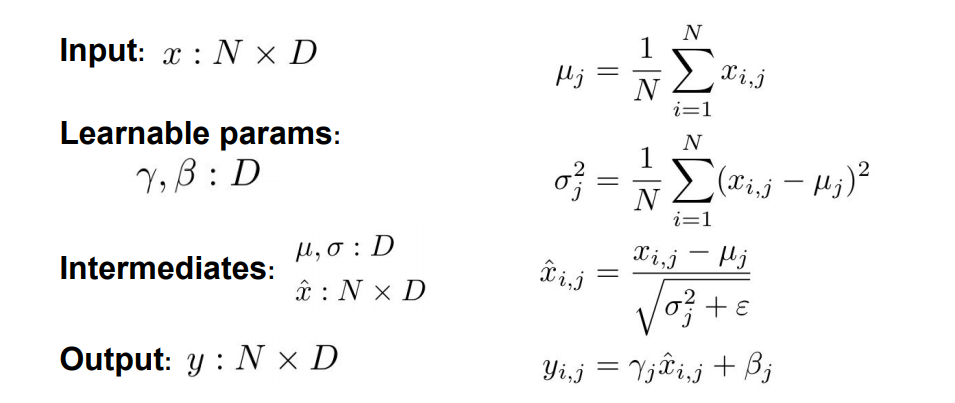

### A quick explanation of the formula
1. For the given input x, we would calculate a mean $\mu$ across all samples
2. Based on the mean $\mu$, we can compute the variances $\sigma$ of each value in the sample
3. We would then normalize the input based on the computed mean and variance
4. Finally, we multiply the value with $\gamma$ and add $\beta$

Please remember that Batch Norm would behave differently at Training and Test Time

# Implementation

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from exercise_code.layers import *
from exercise_code.tests import *
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import os
import shutil

from exercise_code.BatchNormModel import SimpleNetwork, BatchNormNetwork

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from pytorch_lightning.loggers import TensorBoardLogger

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Batch normalization: Forward
In the file `exercise_code/layers.py`, we have implemented the `batchnorm_forward` function. Read this implementation and make sure you understand what batch normalization is doing. Then execute the following cells to test the implementation.

In [2]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [-18.45594671 -16.08765719  14.47626395]
  stds:  [35.57982492 26.43499357 30.83808225]
After batch normalization (gamma=1, beta=0)
  mean:  [2.13162821e-16 4.76285678e-16 3.94129174e-17]
  std:  [1.         0.99999999 0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1.         1.99999999 2.99999998]


In [3]:
# Since the mean and variances in batch norm are computed in training time,
# before invoking the test-time forward pass run the training-time
# forward pass(previous cell) many times to warm up the running averages. Then
# checking the means and variances of activations for a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [ 5718.70665763 -3704.0724807  -5507.86259115]
  stds:  [10466.4600486   8738.84500003 13104.61950519]


## Batch Normalization: backward
Since batch normalization is realized by a more complex function of learnable parameters, it is a good exercise to train your backprop skills through this computational graph.

To this end, implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass. You can stay close to the forward pass implementation we have provided for you, i.e. go line by line backward.

Once you have finished, run the following to numerically check your backward pass.

In [4]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}

fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  3.324355387037525e-08
dgamma error:  7.500379645243704e-12
dbeta error:  2.2756012483533645e-12


## Using Batch Normalization with PyTorch Lightning

Now that we have seen the implementation of BatchNorm layer, it is interesting to see how it would affect the overall Model Performance. Now that we have already seen PyTorch Lightning and how easy it makes our lives, We will use a simple Fully Connected Network in PyTorch. The Principles remain the same but it is good to see how easy frameworks make our lives.

Let us first start with a simple network which does not make use of Batch Norm.

## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations your TensorBoard!

In [5]:
# Few Hyperparameters before we start things off
num_classes = 10
hidden_dim = 200
batch_size = 50

logdir = './batch_norm_logs'
if os.path.exists(logdir):
    # We delete the logs on the first run
    shutil.rmtree(logdir)
os.mkdir(logdir)

epochs = 5
learning_rate = 0.00005

In [6]:
%load_ext tensorboard
%tensorboard --logdir batch_norm_logs

### Model without Batch Normalization. 
Feel free to check `exercise_code/BatchNormModel.py` and play around with the parameters

In [7]:
# train
model = SimpleNetwork(hidden_dim=hidden_dim, batch_size=batch_size, learning_rate=learning_rate)
# Creating a logging object
simple_network_logger = TensorBoardLogger(
    save_dir=logdir,
    name='simple_network'
)
trainer = pl.Trainer(max_epochs=epochs, logger=simple_network_logger)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name    | Type       | Params
-----------------------------------
0 | model   | Sequential | 159 K 
1 | model.0 | Linear     | 157 K 
2 | model.1 | ReLU       | 0     
3 | model.2 | Linear     | 2 K   


Val-Acc=0.001


Val-Acc=0.7545833333333334


Val-Acc=0.7963333333333333


Val-Acc=0.8175833333333333


Val-Acc=0.8250833333333333


Val-Acc=0.8309166666666666



1

### Model incl. Batch Norm
Now that we have already seen how our simple network should work, let us start with the introduction of Batch Norm

In [8]:
model = BatchNormNetwork(hidden_dim=hidden_dim, batch_size=batch_size, learning_rate=learning_rate)
batch_norm_network_logger = TensorBoardLogger(
    save_dir=logdir,
    name='batch_norm_network'
)
trainer = pl.Trainer(max_epochs=epochs, logger=batch_norm_network_logger)
trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name    | Type        | Params
------------------------------------
0 | model   | Sequential  | 159 K 
1 | model.0 | Linear      | 157 K 
2 | model.1 | BatchNorm1d | 400   
3 | model.2 | ReLU        | 0     
4 | model.3 | Linear      | 2 K   


Val-Acc=0.0013333333333333333


Val-Acc=0.8253333333333334


Val-Acc=0.8479166666666667


Val-Acc=0.8560833333333333


Val-Acc=0.8641666666666666


Val-Acc=0.8705



1

In [9]:
%load_ext tensorboard
%tensorboard --logdir batch_norm_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24719), started 0:04:44 ago. (Use '!kill 24719' to kill it.)

## Observations
As you can see, using Batch Norm resulted in better performance. You can easily observe lower validation loss and higher validation accuracy from the graphs. Batch Norm in general is helpful since it would lead to faster model training.

Batch Norm has other related benefits, for instance, it provides a bit of regularization. However, we would look for better methods of regularization such as Dropout. Please take a look at the notebook on Dropout for more details